In [1155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [1156]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

train = train.drop(columns=['id'])

temp_id_test = test['id']
test = test.drop(columns=['id'])

In [1157]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31640 entries, 0 to 31639
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  30772 non-null  float64
 1   person_income               30786 non-null  float64
 2   person_home_ownership       30766 non-null  object 
 3   person_emp_length           30804 non-null  float64
 4   loan_intent                 30792 non-null  object 
 5   loan_grade                  30776 non-null  object 
 6   loan_amnt                   30770 non-null  float64
 7   loan_int_rate               30789 non-null  float64
 8   loan_percent_income         30770 non-null  float64
 9   cb_person_default_on_file   30776 non-null  object 
 10  cb_person_cred_hist_length  30766 non-null  float64
 11  loan_status                 31640 non-null  int64  
dtypes: float64(7), int64(1), object(4)
memory usage: 2.9+ MB


In [1158]:
train = train.rename(columns={
    'person_age' : 'age',
    'person_income' : 'income',
    'person_home_ownership' : 'home',
    'person_emp_length' : 'emp',
    'loan_intent' : 'intent',
    'loan_grade' : 'gra',
    'loan_amnt' : 'amnt',
    'loan_int_rate' : 'rate',
    'loan_percent_income' : 'percome',
    'cb_person_default_on_file' : 'file',
    'cb_person_cred_hist_length' : 'cred',
    'loan_status' : 'status'
})

test = test.rename(columns={
    'person_age' : 'age',
    'person_income' : 'income',
    'person_home_ownership' : 'home',
    'person_emp_length' : 'emp',
    'loan_intent' : 'intent',
    'loan_grade' : 'gra',
    'loan_amnt' : 'amnt',
    'loan_int_rate' : 'rate',
    'loan_percent_income' : 'percome',
    'cb_person_default_on_file' : 'file',
    'cb_person_cred_hist_length' : 'cred'
})

In [1159]:
train.describe()

,age,income,emp,amnt,rate,percome,cred,status
count,30772.000000,30786.000000,30804.000000,30770.000000,30789.000000,30770.000000,30766.000000,31640.000000
mean,27.978032,60261.018710,5.213287,9338.119825,11.768204,0.163322,5.725086,0.254172
std,6.285065,31398.802001,3.450266,5690.231685,3.667865,0.100445,3.966145,0.435402
min,21.000000,11664.000000,0.000046,118.000000,4.917300,0.003064,2.000000,0.000000
25%,24.000000,37753.250000,3.049404,5054.250000,8.089299,0.089005,3.000000,0.000000
50%,26.000000,52644.500000,4.964984,7673.500000,11.420053,0.133358,4.000000,0.000000
75%,30.000000,72326.500000,6.502810,12187.750000,14.087814,0.207660,7.000000,1.000000
max,66.000000,249272.000000,25.100039,33852.000000,22.969506,0.552968,31.000000,1.000000


In [1160]:
train['age'] = train['age'].fillna(train['age'].median())
train['income'] = train['income'].fillna(train['income'].mean())
train['emp'] = train['emp'].fillna(train['emp'].median())
train['amnt'] = train['amnt'].fillna(train['amnt'].mean())
train['rate'] = train['rate'].fillna(train['rate'].median())
train['percome'] = train['percome'].fillna(train['percome'].median())
train['cred'] = train['cred'].fillna(train['cred'].median())
train['home'] = train['home'].fillna("missing")
train['intent'] = train['intent'].fillna("missing")
train['gra'] = train['gra'].fillna('missing')
train['file'] = train['file'].fillna('missing')
train = pd.get_dummies(train, columns=['home', 'intent', 'gra', 'file'], dtype=int)

test['age'] = test['age'].fillna(test['age'].median())
test['income'] = test['income'].fillna(test['income'].mean())
test['emp'] = test['emp'].fillna(test['emp'].median())
test['amnt'] = test['amnt'].fillna(test['amnt'].mean())
test['rate'] = test['rate'].fillna(test['rate'].median())
test['percome'] = test['percome'].fillna(test['percome'].median())
test['cred'] = test['cred'].fillna(test['cred'].median())
test['home'] = test['home'].fillna("missing")
test['intent'] = test['intent'].fillna("missing")
test['gra'] = test['gra'].fillna('missing')
test['file'] = test['file'].fillna('missing')
test = pd.get_dummies(test, columns=['home', 'intent', 'gra', 'file'], dtype=int)

In [1161]:
y = np.array(train['status'])
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[0 1] [23598  8042]


In [1162]:
norm_train = MinMaxScaler().fit_transform(train)
train = pd.DataFrame(norm_train, columns=train.columns)

norm_test = MinMaxScaler().fit_transform(test)
test = pd.DataFrame(norm_test, columns=test.columns)
train

,age,income,emp,amnt,rate,percome,cred,status,home_MORTGAGE,home_OTHER,...,gra_B,gra_C,gra_D,gra_E,gra_F,gra_G,gra_missing,file_N,file_Y,file_missing
0,0.066667,0.335376,0.049051,0.578348,0.352485,0.334442,0.000000,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.133333,0.155504,0.309969,0.162507,0.149326,0.100313,0.068966,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.133333,0.156363,0.150400,0.273318,0.084786,0.207299,0.068966,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.066667,0.125274,0.197250,0.273318,0.312341,0.338033,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.177778,0.586121,0.577172,0.134227,0.132395,0.161976,0.172414,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31635,0.466667,0.101234,0.074976,0.137369,0.149740,0.434319,0.206897,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
31636,0.044444,0.199614,0.066683,0.590650,0.587712,0.369142,0.068966,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
31637,0.111111,0.096600,0.130720,0.186992,0.135725,0.190604,0.034483,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
31638,0.155556,0.502605,0.198446,0.147418,0.152237,0.100422,0.206897,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


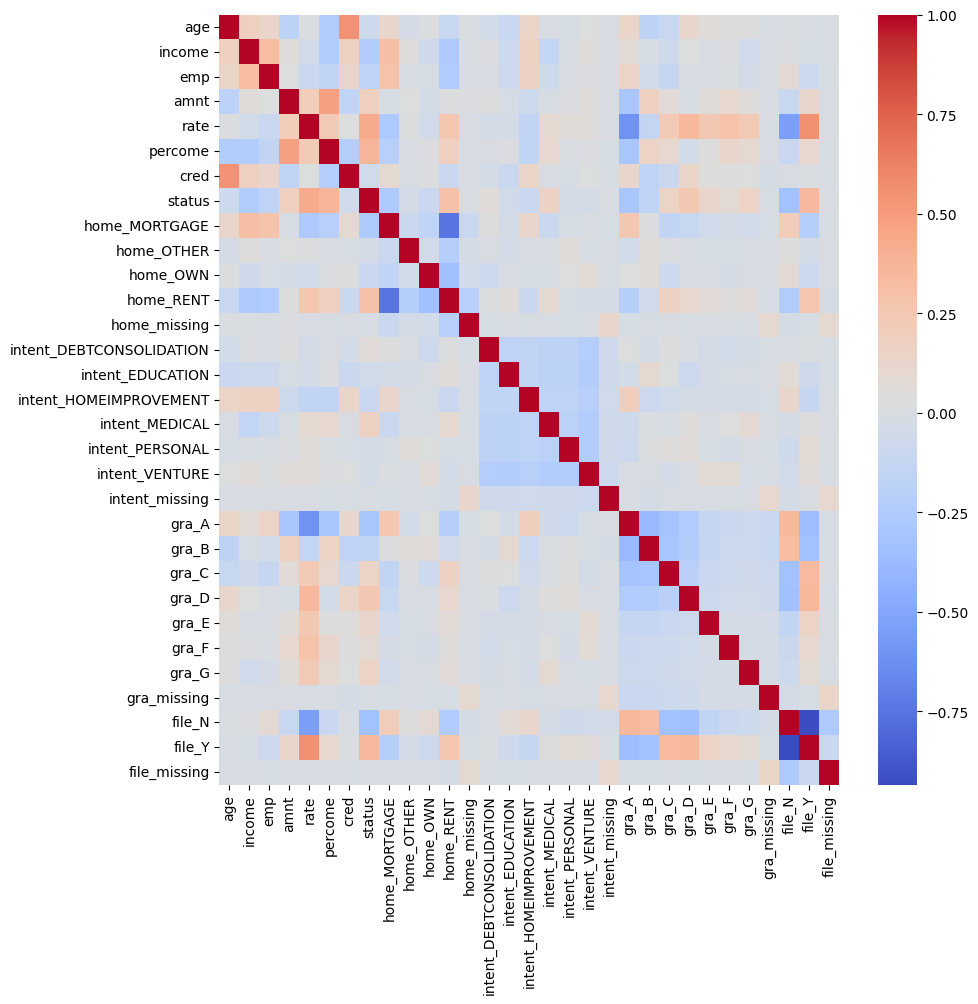

In [1163]:
cor = train.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(cor, cmap='coolwarm')
plt.show()

In [1164]:
temp = list(train.columns)
temp.pop(7)
x = train[temp]
y = train['status']
train_x, train_x_val, train_y, train_y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [1165]:
train_x = train_x.values.astype(np.float32)
train_x_val = train_x_val.values.astype(np.float32)
tensor_train_x = torch.tensor(train_x)
tensor_train_x_val = torch.tensor(train_x_val)

train_y = train_y.values.astype(np.float32).reshape(-1, 1)
train_y_val = train_y_val.values.astype(np.float32).reshape(-1, 1)
tensor_train_y = torch.tensor(train_y)
tensor_train_y_val = torch.tensor(train_y_val)

test_x = test.values.astype(np.float32)
tensor_test_x = torch.tensor(test_x)

In [1166]:
class neural_network(nn.Module):
  def __init__(self, input_body):
    super(neural_network, self).__init__()
    self.layer1 = nn.Linear(input_body, 128)
    self.bn1 = nn.BatchNorm1d(128)

    self.layer2 = nn.Linear(128, 64)
    self.bn2 = nn.BatchNorm1d(64)

    self.layer3 = nn.Linear(64, 32)
    self.bn3 = nn.BatchNorm1d(32)

    self.output = nn.Linear(32, 1)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = torch.relu(self.bn1(self.layer1(x)))
    x = self.dropout(x)
    x = torch.relu(self.bn2(self.layer2(x)))
    x = self.dropout(x)
    x = torch.relu(self.bn3(self.layer3(x)))
    x = self.dropout(x)

    x = self.output(x)

    return x

In [1167]:
def f1_macro(y_pred, y_true, threshold=0.5):
    y_pred = y_pred.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    y_pred_class = (y_pred >= threshold).astype(int)

    f1_scores = []
    for cls in [0, 1]:
        tp = np.sum((y_true == cls) & (y_pred_class == cls))
        fp = np.sum((y_true != cls) & (y_pred_class == cls))
        fn = np.sum((y_true == cls) & (y_pred_class != cls))

        if (tp + fp == 0) or (tp + fn == 0):
            f1 = 0.0
        else:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 0.0 if (precision + recall == 0) else 2 * (precision * recall) / (precision + recall)

        f1_scores.append(f1)

    return np.mean(f1_scores)

Epoch [1/100] | Loss(F1): 0.4258 | Loss(BCE): 1.0294
Epoch [2/100] | Loss(F1): 0.4258 | Loss(BCE): 1.0000
Epoch [3/100] | Loss(F1): 0.4258 | Loss(BCE): 0.9613
Epoch [4/100] | Loss(F1): 0.5241 | Loss(BCE): 0.9179
Epoch [5/100] | Loss(F1): 0.6924 | Loss(BCE): 0.8729
Epoch [6/100] | Loss(F1): 0.7498 | Loss(BCE): 0.8287
Epoch [7/100] | Loss(F1): 0.7643 | Loss(BCE): 0.7892
Epoch [8/100] | Loss(F1): 0.7704 | Loss(BCE): 0.7681
Epoch [9/100] | Loss(F1): 0.7710 | Loss(BCE): 0.7491
Epoch [10/100] | Loss(F1): 0.7715 | Loss(BCE): 0.7323
Epoch [11/100] | Loss(F1): 0.7719 | Loss(BCE): 0.7174
Epoch [12/100] | Loss(F1): 0.7759 | Loss(BCE): 0.7040
Epoch [13/100] | Loss(F1): 0.7779 | Loss(BCE): 0.6927
Epoch [14/100] | Loss(F1): 0.7813 | Loss(BCE): 0.6883
Epoch [15/100] | Loss(F1): 0.7811 | Loss(BCE): 0.6845
Epoch [16/100] | Loss(F1): 0.7823 | Loss(BCE): 0.6813
Epoch [17/100] | Loss(F1): 0.7823 | Loss(BCE): 0.6785
Epoch [18/100] | Loss(F1): 0.7809 | Loss(BCE): 0.6761
Epoch [19/100] | Loss(F1): 0.7807 | L

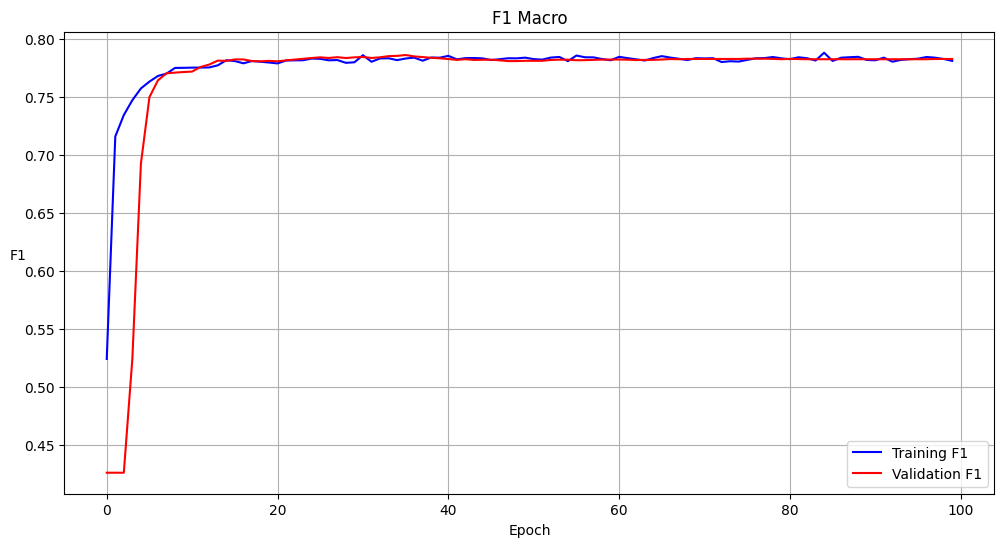

In [1168]:
model = neural_network(train_x.shape[1])
pos_weight = torch.tensor([3.0])
error = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

col_F1, col_F1_val = [], []
epoch, n = 100, 1
for i in range(0, epoch):
  model.train()
  # Forward pass
  y_hat = model(tensor_train_x)
  loss_BCE = error(y_hat, tensor_train_y)
  loss_F1 = f1_macro(y_hat, tensor_train_y)

  # Backward + Optimize
  optimizer.zero_grad()
  loss_BCE.backward()
  optimizer.step()

  with torch.no_grad():
    y_hat = (y_hat >= 0.5).float()
    train_loss_F1 = f1_macro(y_hat, tensor_train_y)
    col_F1.append(train_loss_F1.item())

  model.eval()
  with torch.no_grad():
    y_hat_val = model(tensor_train_x_val)
    loss_BCE_val = error(y_hat_val, tensor_train_y_val)

    y_hat_val = (y_hat_val >= 0.5).float()
    loss_F1_val = f1_macro(y_hat_val, tensor_train_y_val)
    scheduler.step(loss_F1_val)
    col_F1_val.append(loss_F1_val.item())

  if i == (n-1):
    print(f"Epoch [{i+1}/{epoch}] | Loss(F1): {loss_F1_val:.4f} | Loss(BCE): {loss_BCE_val:.4f}")
    n += 1

torch.save(model.state_dict(), 'My_weight.pth')

plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(range(epoch), col_F1, label="Training F1", color="blue")
plt.plot(range(epoch), col_F1_val, label="Validation F1", color="red")
plt.title('F1 Macro')
plt.xlabel('Epoch')
plt.ylabel('F1', rotation=0)
plt.legend()

plt.show()

In [1169]:
with torch.no_grad():
  y_hat = model(tensor_test_x)
  y_hat = (y_hat >= 0.5).float()
  y_hat = y_hat.squeeze().numpy().astype(int)
y_hat = pd.DataFrame(y_hat)

summarize = pd.concat([temp_id_test, y_hat], axis=1)
summarize.columns = ['id', 'loan_status']
summarize.to_csv('My_Answer.csv', index=False)
print(summarize['loan_status'].unique())
summarize

[0 1]


,id,loan_status
0,31641,0
1,31642,1
2,31643,0
3,31644,1
4,31645,0
...,...,...
7905,39546,0
7906,39547,1
7907,39548,0
7908,39549,1
